In [1]:
from IPython.display import Image
Image(url='http://mechanicalforex.com/wp-content/uploads/2011/06/NN.png', width=400, height=600)

## In this notebook, we will train several convolutional neural networks (cNN) for classification and regression to optimize network structure 

The style of this approach is taken from this guide: http://nbviewer.jupyter.org/github/rhiever/Data-Analysis-and-Machine-Learning-Projects/blob/master/example-data-science-notebook/Example%20Machine%20Learning%20Notebook.ipynb 

## 1) Background

#### Type of Analytic Question

Here we will attempt to classify molecules as either actyive or inactive using a set of molecular descriptors

#### Metric of Success

For the classification problem, we can use accuracy - the fraction of correctly classified compounds - as a measure of how well the model of choice is performing. For the regression problem, we may chose from various scoring methods

#### Context for question and the scientific application

This will serve as practic for building and testing a model(s). The comparative 
success of the different models tested will aid in choosing which model to use in future analysis of this type of data.


### Dataset 

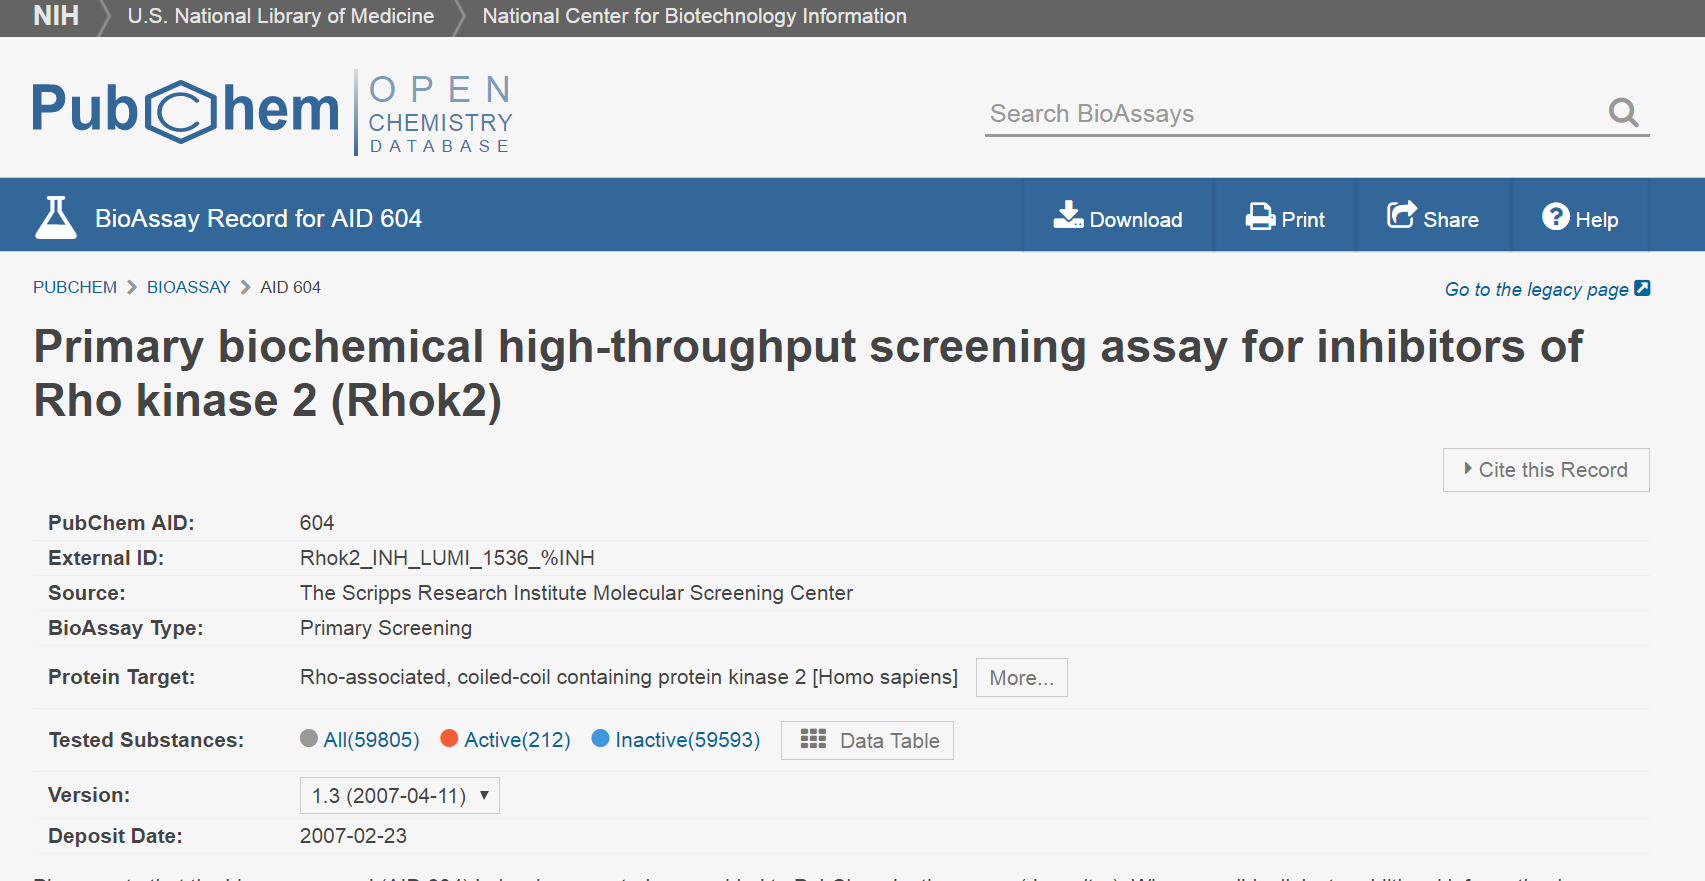

In [2]:
Image('pubchem_rhk2_pic.png', width=900, height=900)

### About the Data

#### See 1st_run_cNN notebook for more details

##### Key points at a glance:

Preliminary screen - may contain false positives* 

Total # of compounds: 59,805

Total # of "active" compounds: 212 

% Active = .35%

##### "Active": 

Prior to inhibition calculations, background signal (i.e. signal from wells containing all reagents except enzyme) was subtracted from test compound and control well values. To calculate percent inhibition the test compound well signal was divided by the median signal from the 100 percent inhibition positive control wells (i.e. wells containing Y-27632) and multiplied by 100.

##### A mathematical algorithm was used to determine nominally inhibitory compounds in the primary screen. Two values were calculated: (1) the average percent inhibition of all compounds tested, and (2) three times their standard deviation. The sum of these two values was used as a cutoff parameter, i.e. any compound that exhibited greater %inhibition than the cutoff parameter was declared active.

The reported Pubchem_Activity_Score has been normalized to 100% of the highest observed primary inhibition. Negative % inhibition values are reported as activity score zero.

*Virtual Screening of Bioassay Data Amanda C Schierz,Smart Technology Research Centre, Bournemouth University, Talbot Campus, Poole, Dorset, BH12 5BB, UK Journal of Cheminformatics 2009, 1:21 doi:10.1186/1758-2946-1-21)


## 2) Checking the Data 

In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image


#### Image data

In [5]:
data = np.genfromtxt("extended_batch_1.csv", delimiter=',')

data = data.astype(float) #Neural net requires float32 type

print("the shape of our data: " + str(data.shape))
print(str(data[0]))
print("the max value of our data: " + str(np.amax(data)))
print("the min value of our data: " + str(np.amin(data)))

the shape of our data: (10128, 10000)
[ 0.91379309  0.91379309  0.91379309 ...,  0.91379309  0.91379309
  0.91379309]
the max value of our data: 1.0
the min value of our data: 0.0


let's visualize a compound of our dataset

<function matplotlib.pyplot.show>

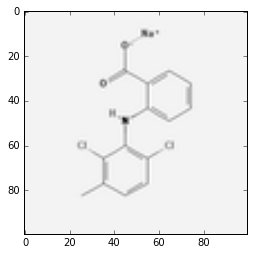

In [6]:
img = data[100]
img = img.reshape(100,100)
plt.imshow(img,cmap='gray')
plt.show

#### labels/targets

In [7]:
labels = np.genfromtxt("labels_set_1.csv", delimiter=',')

In [8]:
print("the shape of our data: " + str(labels.shape))
print(str(labels[0]))


the shape of our data: (10158, 2)
[ 0.  0.]


In [9]:
short_labels = labels[:-30]
len(short_labels)

10128

In [10]:
short_labels

array([[   0.,    0.],
       [   1.,    0.],
       [   2.,    0.],
       ..., 
       [ 125.,    1.],
       [ 126.,    1.],
       [ 127.,    1.]])

In [11]:
short_labels = short_labels[:,1] #to remove the index that was attached when the dataset was used in pandas


In [12]:
#short_labels = short_labels.astype('int32')

print("length: " + str(len(short_labels)))
print("max: " + str(max(short_labels))) #to ensure that we selected the right column

print(short_labels[4019])

length: 10128
max: 1.0
0.0


## 3) Building our Neural Net


In [32]:
import theano

from nolearn.lasagne import NeuralNet #neural net constructor
from nolearn.lasagne.visualize import draw_to_notebook #Visualize structure of cNN

from lasagne.objectives import squared_error
from lasagne.nonlinearities import softmax
from lasagne import layers
from lasagne.updates import nesterov_momentum

from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report

from nolearn.lasagne.visualize import plot_conv_activity

In [33]:
X_train, X_test, y_train, y_test = train_test_split(data, short_labels, test_size=0.33, random_state=52)

#convert data to 2D
def convto2D(data):
    newData = data.reshape(-1,1,100,100)
    return newData

newData = convto2D(X_train)

print(np.shape(X_train))
print(np.shape(newData))

y_train = y_train.astype('int32')

(6785, 10000)
(6785, 1, 100, 100)


In [21]:
conv_net_1 = NeuralNet( 
    layers =[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, 100, 100),
    conv1_num_filters=32, conv1_filter_size=(5, 5), 
    conv2_num_filters=64, conv2_filter_size=(3, 3),
    pool2_pool_size=(2, 2),
    output_num_units=2, output_nonlinearity=softmax,
    
    update_learning_rate=0.01,
    update_momentum=0.9,
    
    max_epochs=8,
    verbose=1, 
    )


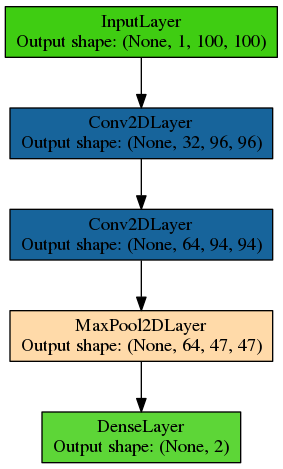

In [34]:
draw_to_notebook(conv_net_1)

In [23]:
newData = newData.astype('float32')

conv_net_1.fit(newData, y_train)

/server-home1/egbert/anaconda3/lib/python3.5/site-packages/lasagne/layers/conv.py:489: UserWarning: The `image_shape` keyword argument to `tensor.nnet.conv2d` is deprecated, it has been renamed to `input_shape`.
  border_mode=border_mode)


# Neural Network with 302082 learnable parameters

## Layer information

  #  name    size
---  ------  ---------
  0  input   1x100x100
  1  conv1   32x96x96
  2  conv2   64x94x94
  3  pool2   64x47x47
  4  output  2

  epoch    trn loss    val loss    trn/val    valid acc  dur
-------  ----------  ----------  ---------  -----------  ------
      1     0.15350     0.09282    1.65375      0.98159  20.35s
      2     0.09077     0.09270    0.97921      0.98159  19.79s
      3     0.09067     0.09262    0.97895      0.98159  20.03s
      4     0.09063     0.09259    0.97884      0.98159  20.25s
      5     0.09060     0.09256    0.97879      0.98159  20.03s
      6     0.09052     0.09260    0.97753      0.98159  19.81s
      7     0.09057     0.09257    0.97846      0.98159  19.83s
      8     0.09052     0.09254    0.97817      0.98159  19.91s


NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x7fb97bc9c9b0>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x7fb97bc9c8d0>,
     check_input=True, conv1_filter_size=(5, 5), conv1_num_filters=32,
     conv2_filter_size=(3, 3), conv2_num_filters=64, custom_scores=None,
     input_shape=(None, 1, 100, 100),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('conv1', <class 'lasagne.layers.conv.Conv2DLayer'>), ('conv2', <class 'lasagne.layers.conv.Conv2DLayer'>), ('pool2', <class 'lasagne.layers.pool.MaxPool2DLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=8, more_params={},
     objective=<function objective at 0x7fb97b16e378>,
     objective_loss_function=<function categorical_crossentropy at 0x7fb97bc8d400>,
     on_batch_finished=[],
     on_epoch_finished=[<nolearn.lasagne.handlers.PrintLog object at 0x7fbb196482b0>],
     on_training_finishe

#### Visualize Convolutional Layers 

/server-home1/egbert/anaconda3/lib/python3.5/site-packages/lasagne/layers/conv.py:489: UserWarning: The `image_shape` keyword argument to `tensor.nnet.conv2d` is deprecated, it has been renamed to `input_shape`.
  border_mode=border_mode)


<module 'matplotlib.pyplot' from '/server-home1/egbert/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py'>

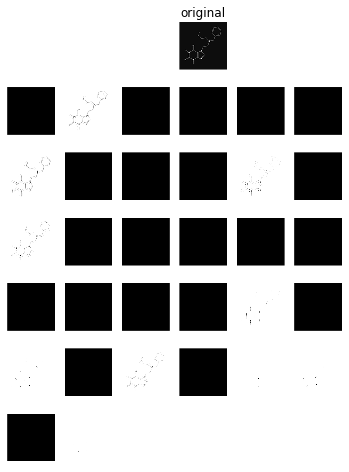

In [24]:
plot_conv_activity(conv_net_1.layers_[1], newData[100:101])

/server-home1/egbert/anaconda3/lib/python3.5/site-packages/lasagne/layers/conv.py:489: UserWarning: The `image_shape` keyword argument to `tensor.nnet.conv2d` is deprecated, it has been renamed to `input_shape`.
  border_mode=border_mode)


<module 'matplotlib.pyplot' from '/server-home1/egbert/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py'>

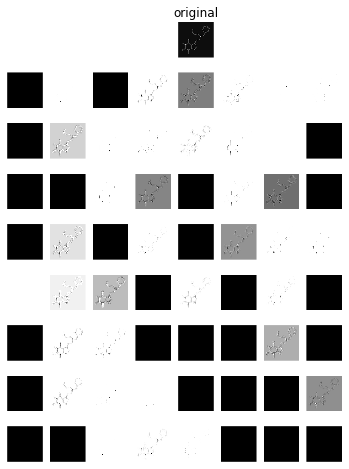

In [25]:
plot_conv_activity(conv_net_1.layers_[2], newData[100:101])

In [26]:
preds1 = conv_net_1.predict(newData)

In [27]:
print(classification_report(y_train, preds1))

             precision    recall  f1-score   support

          0       0.98      1.00      0.99      6664
          1       0.00      0.00      0.00       121

avg / total       0.96      0.98      0.97      6785



/server-home1/egbert/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [28]:
conv_net_2 = NeuralNet( 
    layers =[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('conv3', layers.Conv2DLayer),
        ('hidden1', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, 100, 100),
    conv1_num_filters=32, conv1_filter_size=(5, 5), pool1_pool_size=(2, 2),
    conv2_num_filters=64, conv2_filter_size=(3, 3),
    conv3_num_filters=128, conv3_filter_size=(2, 2),
    hidden1_num_units=500,
    output_num_units=2, output_nonlinearity=softmax,
    
    update_learning_rate=0.01,
    update_momentum=0.9,
    #regression=True,
    
    max_epochs=12,
    verbose=1, 
    )

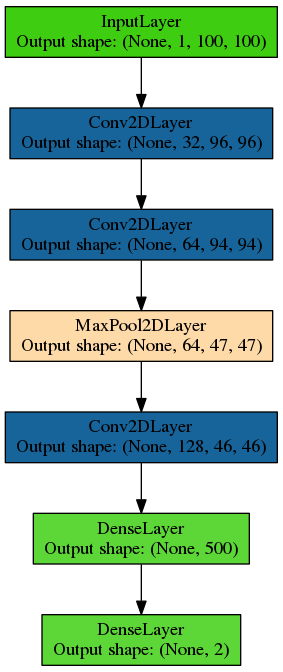

In [35]:
draw_to_notebook(conv_net_2)

In [30]:
newData = newData.astype('float32')
conv_net_2.fit(newData, y_train)

/server-home1/egbert/anaconda3/lib/python3.5/site-packages/lasagne/layers/conv.py:489: UserWarning: The `image_shape` keyword argument to `tensor.nnet.conv2d` is deprecated, it has been renamed to `input_shape`.
  border_mode=border_mode)


# Neural Network with 135477726 learnable parameters

## Layer information

  #  name     size
---  -------  ---------
  0  input    1x100x100
  1  conv1    32x96x96
  2  conv2    64x94x94
  3  pool1    64x47x47
  4  conv3    128x46x46
  5  hidden1  500
  6  output   2

  epoch    trn loss    val loss    trn/val    valid acc  dur
-------  ----------  ----------  ---------  -----------  ------
      1     0.11716     0.09231    1.26923      0.98159  72.98s
      2     0.09034     0.09208    0.98102      0.98159  72.25s
      3     0.09009     0.09194    0.97986      0.98159  72.23s
      4     0.08997     0.09188    0.97925      0.98159  72.24s
      5     0.08986     0.09184    0.97852      0.98159  71.91s
      6     0.08979     0.09184    0.97767      0.98159  72.13s
      7     0.08978     0.09180    0.97801      0.98159  72.21s
      8     0.08971     0.09178    0.97746      0.98159  72.19s
      9     0.08966     0.09179    0.97679      0.98159  72.96s
     10     0.08972     0.09

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x7fb97bc9c9b0>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x7fb97bc9c8d0>,
     check_input=True, conv1_filter_size=(5, 5), conv1_num_filters=32,
     conv2_filter_size=(3, 3), conv2_num_filters=64,
     conv3_filter_size=(2, 2), conv3_num_filters=128, custom_scores=None,
     hidden1_num_units=500, input_shape=(None, 1, 100, 100),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('conv1', <class 'lasagne.layers.conv.Conv2DLayer'>), ('conv2', <class 'lasagne.layers.conv.Conv2DLayer'>), ('pool1', <class 'lasagne.layers.pool.MaxPool2DLayer'>), ('conv3', <class 'lasagne.layers.conv.Conv2DLayer'>), ('hidden1', <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=12, more_params={},
     objective=<function objective at 0x7fb97b16e378>,
     objective_loss_function=<func

/server-home1/egbert/anaconda3/lib/python3.5/site-packages/lasagne/layers/conv.py:489: UserWarning: The `image_shape` keyword argument to `tensor.nnet.conv2d` is deprecated, it has been renamed to `input_shape`.
  border_mode=border_mode)


<module 'matplotlib.pyplot' from '/server-home1/egbert/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py'>

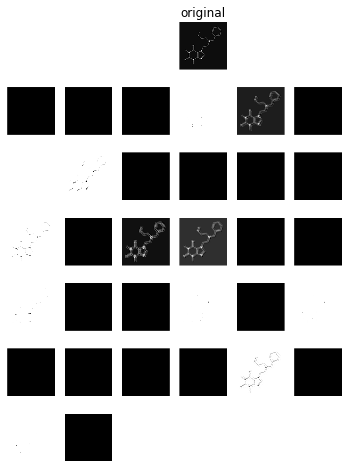

In [127]:
plot_conv_activity(conv_net_2.layers_[1], newData[100:101])

In [131]:
preds2 = conv_net_2.predict(newData)

In [132]:
print(classification_report(y_train, preds2))

             precision    recall  f1-score   support

          0       0.98      1.00      0.99      6664
          1       0.00      0.00      0.00       121

avg / total       0.96      0.98      0.97      6785



/server-home1/egbert/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
##### original net structure #####
'''
conv_net_2 = NeuralNet( 
    layers =[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        @('pool1', layers.MaxPool2DLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('hidden4', layers.DenseLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, 100, 100),
    conv1_num_filters=32, conv1_filter_size=(3, 3), #pool1_pool_size=(2, 2),
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    hidden4_num_units=500, hidden5_num_units=500,
    output_num_units=10, output_nonlinearity=softmax,
    
    update_learning_rate=0.01,
    update_momentum=0.9,
    #regression=True,
    
    max_epochs=12,
    verbose=1, 
    )
'''
###################################



#### Occlusion images and salient plots may help with understanding what the network may be learning

http://nbviewer.jupyter.org/github/dnouri/nolearn/blob/master/docs/notebooks/CNN_tutorial.ipynb